### **Material Derivative (Temperature)**

When the quantity($\phi$) is given as,

$$ \phi=\phi(t,x,y,z) $$

The derivative has to be decribed within time & space:

$$ \frac{D\phi}{Dt} = \frac{\partial \phi}{\partial t} + u \cdot \nabla \phi $$

Then **Material Derivative** defined as an operator:

$$ \frac{D()}{Dt} = \frac{\partial ()}{\partial t} + u \cdot \nabla () $$

So for Temperature:

\begin{equation*} 
\begin{align*}
\rho\frac{De}{Dt} = \rho c_v \frac{DT}{Dt}
&= \rho c_v(\frac{\partial T}{\partial t} + u \cdot \nabla T) \\
&= \nabla \cdot (k\nabla T) - p(\nabla \cdot \mathbf{v}) + {\Phi} + \dot{q}_{gen}
\end{align*}
\end{equation*}

If we regard the material as solid(static, incompressible): **Conduction**,

\begin{equation*} 
\begin{align*}
\rho c_v \frac{DT}{Dt}
&= \rho c_v(\frac{\partial T}{\partial t}) \\
&= \nabla \cdot (k\nabla T) - \dot{q}_{gen} \qquad\qquad \text{Conduction}
\end{align*}
\end{equation*}

For incompressible fluid: **Convection**

\begin{equation*} 
\begin{align*}
\rho c_v \frac{DT}{Dt}
&= \rho c_v(\frac{\partial T}{\partial t} + u \cdot \nabla T) \\
&= \nabla \cdot (k\nabla T) - {\Phi} + \dot{q}_{gen} \qquad \text{Convection}
\end{align*}
\end{equation*}

But this drill only covers simple convection, which ignores viscous effect($\Phi$). \
Therefore, our governing equation:

\begin{equation*} 
\begin{align*}
\rho c_v \frac{DT}{Dt}
&= \rho c_v(\frac{\partial T}{\partial t} + u \cdot \nabla T) \\
&= \nabla \cdot (k\nabla T) +\dot{q}_{gen} \qquad \text{Simple Convection}
\end{align*}
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

In [2]:
def init():
   global IDIM, JDIM, IJDIM
   global NI, NIM, NJ, NJM
   global XP, XU, YP, YV
   global DXP, DXU, DYP, DYV
   global RP, RU
   global T, TSOR, BT
   global U, USOR, BU
   global V, VSOR, BV
   global TKKP, ROCP
   global AW, AE, AN, AS, AP, APC
   global CORR, RES

   # DOMAIN ARRAYS
   XP  = np.zeros(IDIM)
   XU  = np.zeros(IDIM)
   
   ## CONTROL VOLUME SIZE ARRAYS
   DXP = np.zeros(IDIM) 
   DXU = np.zeros(IDIM)
   
   YP  = np.zeros(IDIM)
   YV  = np.zeros(IDIM)
   DYP = np.zeros(IDIM)
   DYV = np.zeros(IDIM)
   
   RP  = np.zeros(IDIM)
   RU  = np.zeros(IDIM)
   
   # TEMPERATURE ARRAYS
   T     = np.zeros((IDIM,JDIM))
   TSOR  = np.zeros((IDIM,JDIM))
   BT    = np.zeros((IDIM,JDIM)) # boundary T
   
   # VELOCITY ARRAYS
   U     = np.zeros((IDIM,JDIM))
   V     = np.zeros((IDIM,JDIM))
   USOR  = np.zeros((IDIM,JDIM))
   VSOR  = np.zeros((IDIM,JDIM))
   BU    = np.zeros((IDIM,JDIM)) 
   BV    = np.zeros((IDIM,JDIM))    

   # PROPERTY COEFFICIENTS
   TKKP = np.zeros((IDIM,JDIM))
   ROCP = np.zeros((IDIM,JDIM))

   # TDMA COEFFICIENTS
   AW   = np.zeros((IDIM,JDIM))
   AE   = np.zeros((IDIM,JDIM))
   AN   = np.zeros((IDIM,JDIM))
   AS   = np.zeros((IDIM,JDIM))
   AP   = np.zeros((IDIM,JDIM))
   APC  = np.zeros((IDIM,JDIM))

   # CORRECTION & RESIDUALS
   CORR   = np.zeros((IDIM,JDIM))
   RES   = np.zeros((IDIM,JDIM))

   ## initialize domain sizes
   for i in range(1,NI+1):  XU[i]=DX0*(i-1)
   for i in range(1,NI):    XP[i]=(XU[i]+XU[i+1])/2
   for j in range(1,NJ+1):  YV[j]=DY0*(j-1)
   for j in range(1,NJ):    YP[j]=(YV[j]+YV[j+1])/2

   XP[0]=XU[1]
   XP[NI]=XU[NI]
   YP[0]=YV[1]
   YP[NJ]=YV[NJ]

   ## initialize control volume sizes
   for i in range(1,NI):    DXP[i]=XU[i+1]-XU[i]
   for i in range(1,NI+1):  DXU[i]=XP[i]-XP[i-1]
   for j in range(1,NJ):    DYP[j]=YV[j+1]-YV[j]
   for j in range(1,NJ+1):  DYV[j]=YP[j]-YP[j-1]

   ## initialize face dimensions
   if IR==0:
      for i in range(1,NI+1): RU[i]=1
      for i in range(0,NI+1): RP[i]=1
   else:
      for i in range(1,NI+1): RU[i]=np.fabs(XU[i])
      for i in range(0,NI+1): RP[i]=np.fabs(XP[i])

In [3]:
np.set_printoptions(
    threshold=np.inf,  
    precision=3,       
    suppress=True,     
    linewidth=200      
)

def divideByZeroWarn(val,funcName):
    if np.abs(val)<=1e-30:
        message="WARNING: denominator {} is zero!!".format(val)
        message+="\t FROM:{}".format(funcName)
        print(message)

def TDMA(start, end, AW, AE, AP, SOR):
    X = np.zeros(IJDIM)
    c_prime = np.zeros(IJDIM)
    d_prime = np.zeros(IJDIM)
    
    denom=AP[start]
    divideByZeroWarn(denom,TDMA.__name__)

    c_prime[start] = AE[start] / denom
    d_prime[start] = SOR[start] / denom
    
    for i in range(start + 1, end + 1):

        denom=(AP[i] - AW[i] * c_prime[i - 1])
        divideByZeroWarn(denom,TDMA.__name__)

        c_prime[i] = AE[i] / denom
        d_prime[i] = (SOR[i] - AW[i] * d_prime[i - 1]) / denom
    X[end] = d_prime[end]
    for i in range(end - 1, start - 1, -1):
        X[i] = d_prime[i] - c_prime[i] * X[i + 1]

    return X

def LLTDMA(i_start, i_end, j_start, j_end, AW, AE, AS, AN, AP, SOR):
    SOR_x = np.zeros(IDIM)
    SOR_y = np.zeros(JDIM)
    X = np.zeros((IDIM, JDIM))

    for iter in range(2):
        # TDMA: x-direction
        for j in range(j_start, j_end+1):
            for i in range(i_start, i_end + 1):
                neighbors = AS[i][j] * X[i][j - 1] + AN[i][j] * X[i][j + 1]
                SOR_x[i] = SOR[i][j] + neighbors
            X[:, j]=TDMA(i_start, i_end, -AW[:, j], -AE[:, j], AP[:, j], SOR_x)
        
    
        # TDMA: y-direction
        for i in range(i_start, i_end+1):
            for j in range(j_start, j_end + 1):
                neighbors = AW[i][j] * X[i - 1][j] + AE[i][j] * X[i + 1][j]
                SOR_y[j] = SOR[i][j] + neighbors
            X[i, :] = TDMA(j_start, j_end, -AS[i, :], -AN[i, :], AP[i, :], SOR_y)

    return X

### **2D Thermal Conduction & Convection**

Governing equation considering: Conduction and Convection

\begin{equation*}
\begin{align*}
\rho c_p \left(\frac{\partial T}{\partial t} + \underbrace{u\frac{\partial T}{\partial x} + v\frac{\partial T}{\partial y}}_\text{convection term} \right)
&= \underbrace{\frac{1}{r} \frac{\partial}{\partial x} \left( k r \frac{\partial T}{\partial x} \right)
+ \frac{\partial}{\partial y} \left( k \frac{\partial T}{\partial y} \right)}_\text{conduction term}
+ \underbrace{\dot{q}}_\text{source term} \\[4em]
\end{align*}
\end{equation*}



##### **Conduction Term** 

\begin{equation}
\begin{align*}
\text{conduction term}
&=\frac{1}{r} \frac{\partial}{\partial x} \left( k r \frac{\partial T}{\partial x} \right)
+ \frac{\partial}{\partial y} \left( k \frac{\partial T}{\partial y} \right) \\[1em]
&=\int_{y_{j-\frac{1}{2}}}^{y_{j+\frac{1}{2}}} \int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}
\left[
\frac{1}{r} \frac{\partial}{\partial x} \left( k r \frac{\partial T}{\partial x} \right)
+ \frac{\partial}{\partial y} \left( k \frac{\partial T}{\partial y} \right)
\right] r \, dx \, dy\\[3em]

\text{discretized form}
&=\left[
(k r \Delta y)_{i+\frac{1}{2},j}
\frac{T_{i+1,j} - T_{i,j}}{(\Delta x)_{i+\frac{1}{2}}}
-
(k r \Delta y)_{i-\frac{1}{2},j}
\frac{T_{i,j} - T_{i-1,j}}{(\Delta x)_{i-\frac{1}{2}}}
\right] \\
&+
\left[
(k r \Delta x)_{i,j+\frac{1}{2}}
\frac{T_{i,j+1} - T_{i,j}}{(\Delta y)_{j+\frac{1}{2}}}
-
(k r \Delta x)_{i,j-\frac{1}{2}}
\frac{T_{i,j} - T_{i,j-1}}{(\Delta y)_{j-\frac{1}{2}}}
\right] \\

\end{align*}
\end{equation}

##### **Convection Term**

\begin{equation*}
\begin{align*}
\text{convection term}
&= \rho c_p \left(u\frac{\partial T}{\partial x} + v\frac{\partial T}{\partial y}\right) \\ 

&= \int_{y_{j-\frac{1}{2}}}^{y_{j+\frac{1}{2}}} \int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}
\rho c_p \left[
\left(\frac{1}{r}\frac{\partial (ruT)}{\partial x} - \frac{T}{r}\frac{\partial (ru)}{\partial x}\right) 
+ \left(\frac{1}{r}\frac{\partial (rvT)}{\partial y} - \frac{T}{r}\frac{\partial (rv)}{\partial y}\right) 
\right] \, r \, dx \, dy \\[3em]


\text{discretized form}
&= \left( \rho c_p \, \Delta y \right)_{i,j} 
\left(
\left( (ruT)_{i+\frac{1}{2},j} - (ruT)_{i-\frac{1}{2},j} \right) -
\left( (ru)_{i+\frac{1}{2},j} - (ru)_{i-\frac{1}{2},j} \right) T_{i,j} 
\right)\\

&+\left( \rho c_p \, \Delta x \right)_{i,j} 
\left(
\left( (rvT)_{i,j+\frac{1}{2}} - (rvT)_{i,j-\frac{1}{2}} \right) -
\left( (rv)_{i,j+\frac{1}{2}} - (rv)_{i,j-\frac{1}{2}} \right) T_{i,j} 
\right)\\

\end{align*}
\end{equation*}


### **Deferred Correction(Semi-Implicit Method)**
Since our solver: LLTDMA is designed to solve linear matrices, solving 2nd order scheme(MUSCL) equation is not preferable.\
That is, we cannot split minmod outputs into 4-directinal coefficients.

The idea of this method is setting LHS implicitly with first order and RHS explicitly with second order. So we can call this method as "Semi-Implicit" method.


##### **First Order Implicit (LHS)**
##### **Second Order Explicit (RHS)**

### **Upwind Scheme**

### **MUSCL: Monotonic Upstream-centered Scheme for Conservation Laws**

**Upwind Scheme**

Select quantity for $\Phi_{i+\frac{1}{2}}$ either $\Phi_i$ or $\Phi_{i+1}$. \
Remind that Upwind Velocity $U$ is defined at the face

\begin{equation*}
\Phi_{i+\frac{1}{2}} = 
\left\{ 
\begin{array}{rcl}
\Phi_i & U_{i+\frac{1}{2}} > 0 \\
\Phi_{i+1} & U_{i+\frac{1}{2}} < 0
\end{array}
\right\}
\end{equation*}

**Non-linear Central Differential Scheme (2nd order)**


### **Deferred Correction (Semi-Implicit Method)**

Since our solver: LLTDMA is designed to solve linear matrices, solving 2nd order scheme(MUSCL) equation is not preferable.\
That is, we cannot split minmod outputs into 4-directinal coefficients.

Then, we can implictly approximate coefficients with centered values:

$$
T_{i-1/2,j} \approx T_{i-1,j}
$$

In [4]:
def set_BC(TW, TE, TS, TN):
    global T
    for j in range(0, NJ): T[0][j] = TW  # West Wall
    for j in range(0, NJ): T[NI][j] = TE  # East Wall
    for i in range(0, NI): T[i][0] = TS  # South Wall
    for i in range(0, NI): T[i][NJ] = TN  # North Wall

def set_NEUMANN(option, flag):
    if option is None:
        return
    
    if flag == "pre":
        for j in range(1, NJ):
            if option.get("W") == "neumann": 
                AP[1][j] -= AW[1][j]
                AW[1][j] = 0
            if option.get("E") == "neumann": 
                AP[NIM][j] -= AE[NIM][j]
                AE[NIM][j] = 0
        for i in range(1, NI):
            if option.get("S") == "neumann": 
                AP[i][1] -= AS[i][1]
                AS[i][1] = 0
            if option.get("N") == "neumann": 
                AP[i][NJM] -= AN[i][NJM]
                AN[i][NJM] = 0 
        return

    if flag == "post":
        for j in range(1, NJ):
            if option.get("W") == "neumann": T[0][j] = T[1][j]
            if option.get("E") == "neumann": T[NI][j] = T[NIM][j]
        for i in range(1, NI):
            if option.get("S") == "neumann": T[i][0] = T[i][1]
            if option.get("N") == "neumann": T[i][NJ] = T[i][NJM]
        return

def outOfRangeWarn(i,j):
    if i>NI:
        print("WARNING: index i={0} Out Of Range NI={1}".format(i,NI))
    if j>NJ:
        print("WARNING: index j={0} Out Of Range NJ={1}".format(j,NJ))

def minmod(a, b):
    if a * b <= 0:  return 0.0
    if a < 0:       return np.fmax(a, b)
    else:           return np.fmin(a, b)


def get_upwind(i, j, dim):
    global U, V

    if dim not in ["x", "y"]: AssertionError
    if dim == "x":
        if U[i][j] >= 0: return (i, j)
        return (i + 1, j)
    if dim == "y":
        if V[i][j] >= 0: return (i, j)
        return (i, j + 1)


def get_faceVal(i, j, dim, scheme=None):  # MUSCL ALGORITHM
    global T

    (u_i, u_j) = get_upwind(i, j, dim)
    outOfRangeWarn(u_i,u_j)
    
    if dim == "x":
        r_diff = T[u_i + 1][u_j] - T[u_i][u_j]
        l_diff = T[u_i][u_j] - T[u_i - 1][u_j]
    if dim == "y":
        r_diff = T[u_i][u_j + 1] - T[u_i][u_j]
        l_diff = T[u_i][u_j] - T[u_i][u_j - 1]
    diff = minmod(r_diff, l_diff)
    sign = (-1) ** ((u_i - i) + (u_j - j))

    T_right = T[u_i][u_j] + sign * 0.5 * diff

    return T_right

def get_RES():
    global T, U, V
    global TSOR
    global NI, NJ
    global RHO, CP

    CONV = np.zeros((IDIM, JDIM))

    RESMAX = 0
    FFMAX = 0
    FCMAX = 0
    for i in range(1, NI):
        for j in range(1, NJ):

            flux_W = RHO * CP * RU[i] * DYP[j] * U[i][j]
            flux_E = RHO * CP * RU[i + 1] * DYP[j] * U[i + 1][j]
            flux_S = RHO * CP * RP[i] * DXP[i] * V[i][j]
            flux_N = RHO * CP * RP[i] * DXP[i] * V[i][j + 1]

            neighbors = (
                AW[i][j] * T[i - 1][j]
                + AE[i][j] * T[i + 1][j]
                + AS[i][j] * T[i][j - 1]
                + AN[i][j] * T[i][j + 1]
            )
            FOU = AP[i][j] * T[i][j] - neighbors
        

            x_conv_1 = flux_E * get_faceVal(i, j, "x") - flux_W * get_faceVal(i - 1, j, "x")
            y_conv_1 = flux_N * get_faceVal(i, j, "y") - flux_S * get_faceVal(i, j - 1, "y")

            x_conv_2 = (np.fmax(0, flux_E) * T[i][j] + np.fmax(0, -flux_E) * T[i+1][j]) \
                       - (np.fmax(0, flux_W) * T[i-1][j] + np.fmax(0, -flux_W) * T[i][j])
                       
            y_conv_2 = (np.fmax(0, flux_N) * T[i][j] + np.fmax(0, -flux_N) * T[i][j+1]) \
                       - (np.fmax(0, flux_S) * T[i][j-1] + np.fmax(0, -flux_S) * T[i][j])

            x_conv = x_conv_1 - x_conv_2
            y_conv = y_conv_1 - y_conv_2
            conv = x_conv + y_conv

            SOU = FOU + conv

            # residual & correction
            RES[i][j] = TSOR[i][j] - SOU
            RESMAX = max(RESMAX, np.fabs(RES[i][j] / AP[i][j]))
            FFMAX = max(FFMAX, np.fabs(T[i][j]))
            FCMAX = max(FCMAX, np.fabs(CORR[i][j]))

    FFMAX = max(1.0e-30, FFMAX)
    RESMAX = RESMAX / FFMAX
    FCMAX = FCMAX / FFMAX

    return (RES, RESMAX, FFMAX, FCMAX)


def monitor_RES(iter, resmax, fcmax):
    global T
    global JUMP, ERRMAX
    is_continue = 1

    if iter % JUMP == 0:
        print(
            " iter= {:4d} T= {:11.3e} ResMax= {:11.3e} Fcmax= {:11.3e}".format(
                iter, T[int(NI/2)][int(NJ/2)], resmax, fcmax
            )
        )
    if iter and resmax < ERRMAX and fcmax < ERRMAX:
        print(
            " iter= {:4d} T= {:11.3e} ResMax= {:11.3e} Fcmax= {:11.3e}".format(
                iter, T[int(NI/2)][int(NJ/2)], resmax, fcmax
            )
        )
        is_continue = 0
    return is_continue


def debug_ARR(ARR):
    print(ARR)


def solve_T(option=None):
    global CORR
    global T

    # TDMA coeffs
    for i in range(1, NI):
        for j in range(1, NJ):
            _AW = K0 * RU[i] * DYP[j] / DXU[i]
            _AE = K0 * RU[i + 1] * DYP[j] / DXU[i + 1]
            _AS = K0 * RP[i] * DXP[i] / DYV[j]
            _AN = K0 * RP[i] * DXP[i] / DYV[j + 1]

            # First Order Upwind(Implicit)
            flux_W = RHO * CP * RU[i] * DYP[j] * U[i][j]
            flux_E = RHO * CP * RU[i + 1] * DYP[j] * U[i + 1][j]
            flux_S = RHO * CP * RP[i] * DXP[i] * V[i][j]
            flux_N = RHO * CP * RP[i] * DXP[i] * V[i][j + 1]

            AW[i][j] = _AW + np.fmax(0, flux_W)
            AE[i][j] = _AE + np.fmax(0, -flux_E)
            AS[i][j] = _AS + np.fmax(0, flux_S)
            AN[i][j] = _AN + np.fmax(0, -flux_N)
            AP[i][j] = AW[i][j] + AE[i][j] + AS[i][j] + AN[i][j]

            TSOR[i][j] = QDOT * RP[i] * DXP[i] * DYP[j]
            
    # boundary conds
    set_NEUMANN(option, "pre")

    # earn T_hat (T_numerical)
    for iter in range(ITERMAX):
        (RES, RESMAX, FFMAX, FCMAX) = get_RES()
        if monitor_RES(iter, RESMAX, FCMAX) == 0:
            break

        CORR = LLTDMA(1, NIM, 1, NJM, AW, AE, AS, AN, AP, SOR=RES)
        for i in range(1, NI):
            for j in range(1, NJ):
                T[i][j] += T_RELAX * CORR[i][j]

        set_NEUMANN(option, "post")

    return T

In [5]:
def plot_results(input_T):
    x_coords = XP[1:NI] 
    y_coords = YP[1:NJ] 

    T_data = input_T[1:NI, 1:NJ]
    X_plot, Y_plot = np.meshgrid(x_coords, y_coords)
    T_plot = T_data.T
    
    plt.figure(figsize=(8, 6))
    contour_fill = plt.contourf(X_plot, Y_plot, T_plot, levels=15, cmap='jet')
    contour_lines = plt.contour(X_plot, Y_plot, T_plot, levels=15, colors='black', linewidths=0.5)
    
    plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    plt.title(f'Temperature Distribution ({NIM}x{NJM} Grid)')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.colorbar(contour_fill, label='Temperature') 
    plt.axis('equal') 
    
    plt.show()

In [6]:
IJDIM=100
IDIM=100
JDIM=100

NI = 21
NJ = 21
NIM = NI - 1
NJM = NJ - 1
DX0 = 1/(NI-1)
DY0 = 1/(NJ-1)
IR = 0

K0 = 1.0
# ROCP0 = 1.e6
QDOT = 0.0
ERRMAX = 1.0e-5
T_RELAX = 1.0
RHO = 1.e3
CP = 1.e3

ITERMAX = 1000
JUMP = 10

V0 = 1e-6
U0 = 0

---------------Case 1: TW=0, TE=0, TS=0, TN=1---------------
 iter=    0 T=   0.000e+00 ResMax=   4.938e+29 Fcmax=   0.000e+00
 iter=   10 T=   1.681e-01 ResMax=   1.897e-03 Fcmax=   2.320e-02
 iter=   20 T=   2.861e-01 ResMax=   6.350e-04 Fcmax=   7.861e-03
 iter=   30 T=   3.293e-01 ResMax=   2.269e-04 Fcmax=   2.858e-03
 iter=   40 T=   3.449e-01 ResMax=   8.215e-05 Fcmax=   1.037e-03
 iter=   50 T=   3.506e-01 ResMax=   2.976e-05 Fcmax=   3.755e-04
 iter=   60 T=   3.526e-01 ResMax=   1.078e-05 Fcmax=   1.360e-04
 iter=   70 T=   3.534e-01 ResMax=   3.902e-06 Fcmax=   4.924e-05
 iter=   80 T=   3.536e-01 ResMax=   1.413e-06 Fcmax=   1.783e-05
 iter=   86 T=   3.537e-01 ResMax=   7.680e-07 Fcmax=   9.692e-06
------------------------------------------------------------


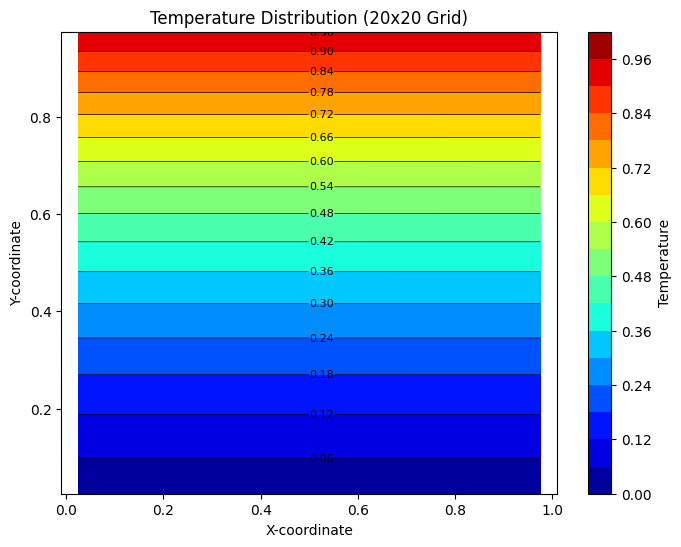

In [7]:
print("---------------Case 1: TW=0, TE=0, TS=0, TN=1---------------")
init()
for i in range(0,NI): 
   for j in range(0,NJ): 
      U[i][j]=U0
      V[i][j]=V0
set_BC(TW=0, TE=0, TS=0, TN=1)
case1=solve_T(option={"E":"neumann", "W":"neumann"})
print("------------------------------------------------------------")
plot_results(case1)

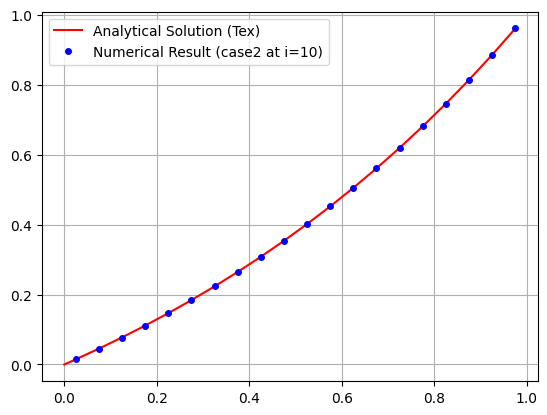

In [8]:
# Tex (분석해) 플롯
Pe = RHO * CP * V0 * (YP[NJ]-YP[0]) / K0 # Pe = (rho*cp*V*L)/k (L=1.0)
Tex = np.zeros(JDIM)
for j in range(0, NJ+1):
    Tex[j] = (np.exp(Pe * YP[j]) - 1.) / (np.exp(Pe) - 1.)

plt.plot(YP[0:NJ], Tex[0:NJ], 'r-', label="Analytical Solution (Tex)")

# case2 (수치해) 플롯 (중앙 x위치에서 y방향으로 플롯)
mid_i = int(NI / 2)
plt.plot(YP[1:NJ], case1[mid_i, 1:NJ], 'bo', markersize=4, label=f"Numerical Result (case2 at i={mid_i})")

plt.legend()
plt.grid(True)
plt.show()

---------------Case 2: TW=0, TE=0, TS=0, TN=1---------------
 iter=    0 T=   0.000e+00 ResMax=   4.938e+29 Fcmax=   0.000e+00
 iter=   10 T=   1.421e-01 ResMax=   1.847e-03 Fcmax=   2.135e-02
 iter=   20 T=   2.378e-01 ResMax=   1.345e-03 Fcmax=   1.087e-02
 iter=   30 T=   2.896e-01 ResMax=   9.308e-04 Fcmax=   7.584e-03
 iter=   40 T=   3.226e-01 ResMax=   6.122e-04 Fcmax=   4.993e-03
 iter=   50 T=   3.440e-01 ResMax=   4.002e-04 Fcmax=   3.265e-03
 iter=   60 T=   3.581e-01 ResMax=   2.616e-04 Fcmax=   2.134e-03
 iter=   70 T=   3.673e-01 ResMax=   1.710e-04 Fcmax=   1.395e-03
 iter=   80 T=   3.733e-01 ResMax=   1.118e-04 Fcmax=   9.124e-04
 iter=   90 T=   3.772e-01 ResMax=   7.316e-05 Fcmax=   5.968e-04
 iter=  100 T=   3.798e-01 ResMax=   4.786e-05 Fcmax=   3.904e-04
 iter=  110 T=   3.815e-01 ResMax=   3.131e-05 Fcmax=   2.554e-04
 iter=  120 T=   3.826e-01 ResMax=   2.049e-05 Fcmax=   1.671e-04
 iter=  130 T=   3.833e-01 ResMax=   1.340e-05 Fcmax=   1.093e-04
 iter=  140 T= 

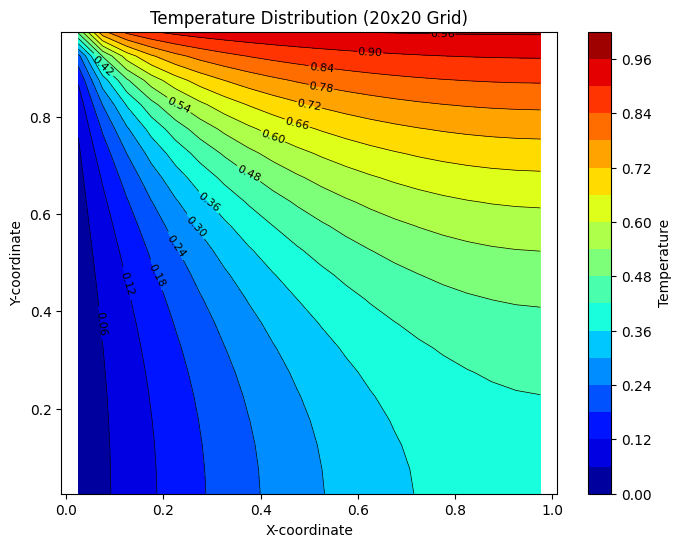

In [9]:
print("---------------Case 2: TW=0, TE=0, TS=0, TN=1---------------")
init()
for i in range(0,NI): 
   for j in range(0,NJ): 
      U[i][j]=U0
      V[i][j]=V0
set_BC(TW=0, TE=0, TS=0, TN=1)
case2=solve_T(option={"S":"neumann", "E":"neumann"})
print("------------------------------------------------------------")
plot_results(case2)

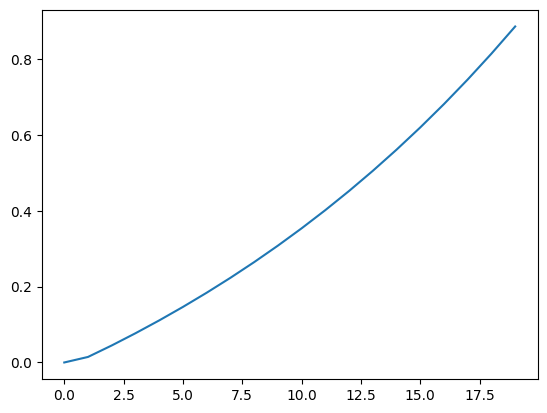

In [10]:
plt.plot(case1[18,:20])

In [11]:
TREF=np.loadtxt("T_REF.txt")

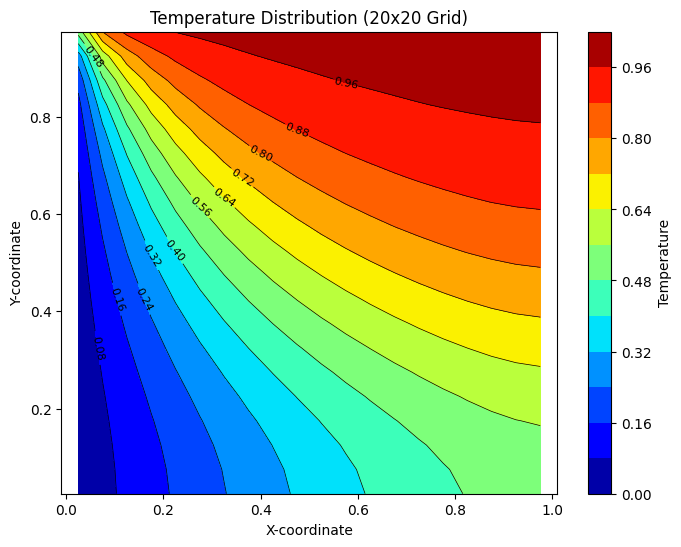

In [12]:
plot_results(TREF)